<a href="https://colab.research.google.com/github/sippam/PMU-B-PersonalAI/blob/main/BiTNet%3A-AI-for-diagnosing-ultrasound-image/Sippakorn_PMUB_Personal_AI_Image_classification_EfficientNetB5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats vs Dogs : Image Classification using EfficienNet

## Data Description

**The training archive contains 25,000 images of dogs and cats.**


## Install

In [1]:
!pip install efficientnet
!pip install --upgrade tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 re

## Loading Libraries

> TensorFlow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Basic
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd
from PIL import Image, ImageFile

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras import callbacks
from keras.callbacks import Callback
from keras import layers
from keras import models
from tensorflow.keras import optimizers
from keras.optimizers import Adam
from efficientnet.keras import center_crop_and_resize, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [5]:
dataset_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'

## Data Extraction

In [6]:
data_dir = '/content/sample_data'
%cd '/content/sample_data'
!pwd

/content/sample_data
/content/sample_data


In [7]:
path_to_downloaded_file = tf.keras.utils.get_file(
    origin=dataset_url,
    extract=False,
)

824887076/824887076 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [8]:
path_to_downloaded_file

'/root/.keras/datasets/kagglecatsanddogs_5340.zip'

In [9]:
import zipfile

with zipfile.ZipFile(path_to_downloaded_file, 'r') as zipp:
    zipp.extractall(data_dir)

In [10]:
import glob

Cat_count = len(list(glob.glob(f'{data_dir}/PetImages/Cat/*.jpg')))
print('Cat: ', Cat_count)

Dog_count = len(list(glob.glob(f'{data_dir}/PetImages/Dog/*.jpg')))
print('Dog: ', Dog_count)

Cat:  12500
Dog:  12500


### Loading Images in a Dataframe

In [12]:
df_dada = pd.DataFrame(columns=['filename', 'label'])
list_dir = ["Cat", "Dog"]
dataframes = []
for label in list_dir:
    filenames = list(glob.glob(f'{data_dir}/PetImages/{label}/*.jpg'))
    #labels = [x.split("/")[3] for x in filenames]
    data = pd.DataFrame({"filename": filenames, "label": label})
    data = data.iloc[:1250,]
    # df_dada = df_dada.append(data)
    dataframes.append(data)

df_dada = pd.concat(dataframes, ignore_index=True)

print(df_dada.shape)
df_dada.head()

(2500, 2)


filename label
0   /content/sample_data/PetImages/Cat/9508.jpg   Cat
1    /content/sample_data/PetImages/Cat/621.jpg   Cat
2   /content/sample_data/PetImages/Cat/8825.jpg   Cat
3   /content/sample_data/PetImages/Cat/3714.jpg   Cat
4  /content/sample_data/PetImages/Cat/12054.jpg   Cat

## Data Exploration

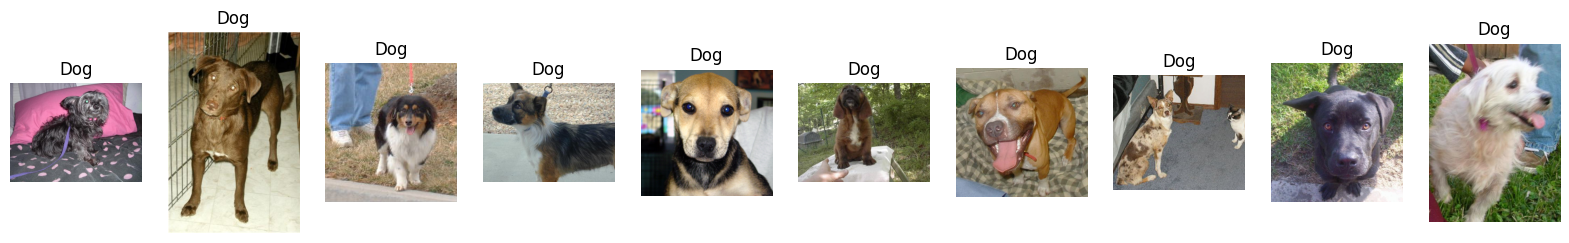

In [13]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = f'{data_dir}/PetImages/Dog/{str(i)}.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

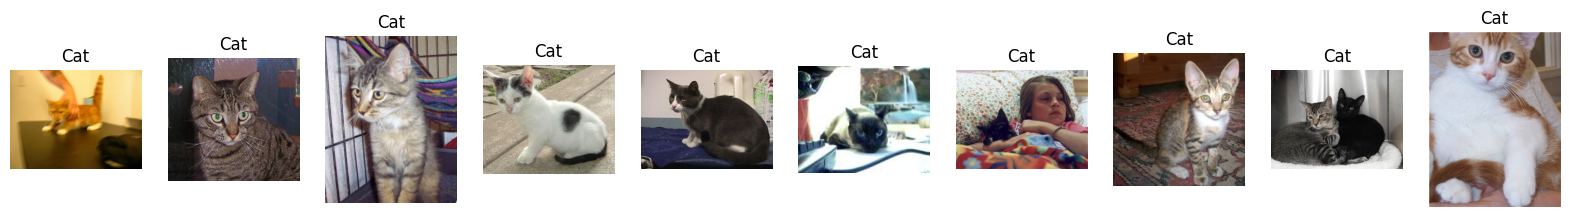

In [14]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = f'{data_dir}/PetImages/Cat/{str(i)}.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat',fontsize=12)
    plt.axis('off')

### Train Test Split

In [15]:
# train test split using dataframe

labels = df_dada['label']

X_train, X_temp = train_test_split(df_dada, test_size=0.2, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (2000, 2)
The shape of test data (250, 2)
The shape of validation data (250, 2)


<ipython-input-16-418fb063fcee>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
<ipython-input-16-418fb063fcee>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',width=0.2).set_title('Class distribution in validation set',fontsize=15)
<ipython-input-16-418fb063fcee>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',w

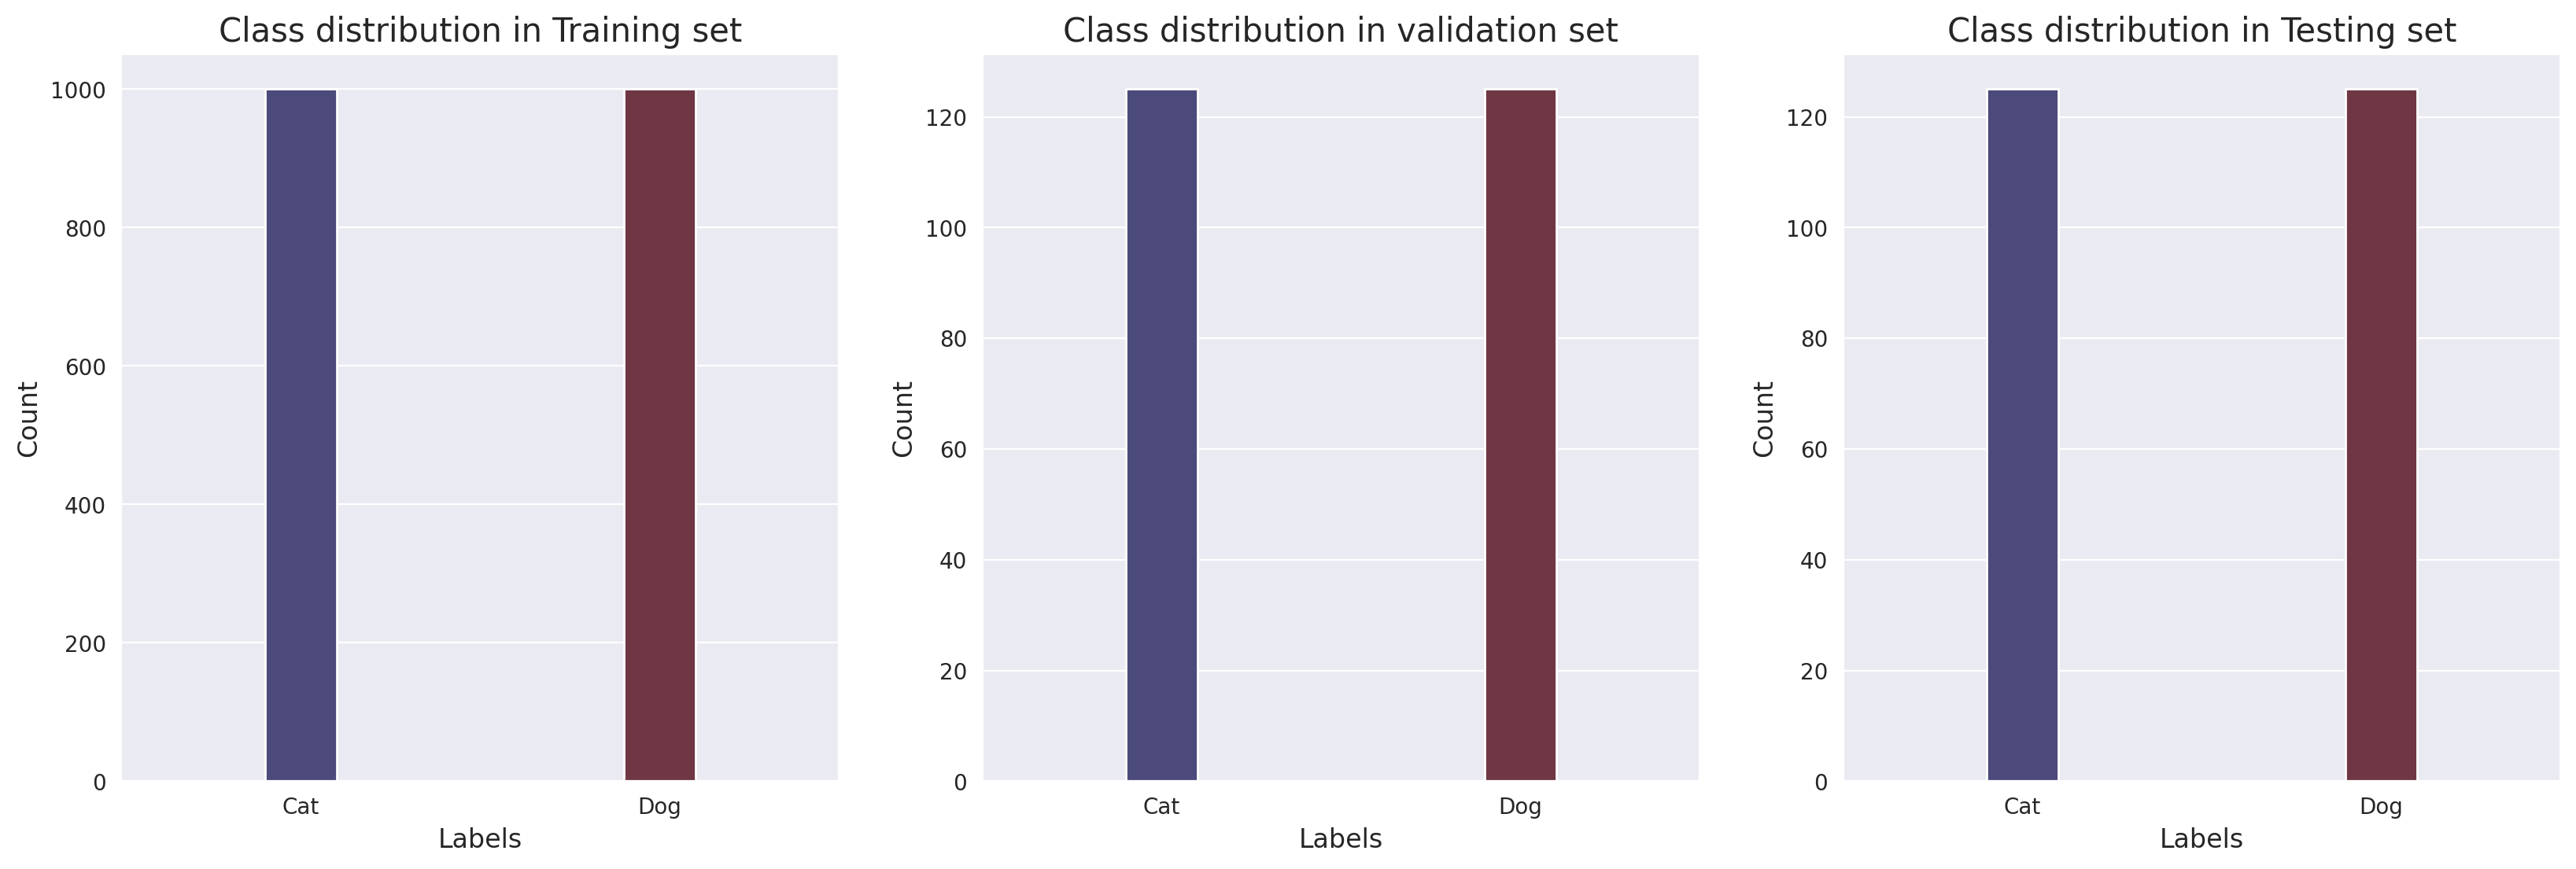

In [16]:
labels = ['Cat','Dog']

label1,count1 = np.unique(X_train.label,return_counts=True)
label2,count2 = np.unique(X_val.label,return_counts=True)
label3,count3 = np.unique(X_test.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])


plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',width=0.2).set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',width=0.2).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

### Data Preparation

In [17]:
# parameters
target_size = (456, 456)
batch_size = 16

### Image Data Generator

-  The data for will used by flow_from_dataframe.

- The batch size is 16 and the image size is (456, 456).

In [18]:
# Creating image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'nearest',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
# Applying image data gernerator to train and test data

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = None,
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = batch_size,
                                                    target_size = target_size,
                                                    class_mode='categorical',
                                                    color_mode= 'rgb'
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val,
                                                 directory = None,
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = batch_size,
                                                 target_size = target_size,
                                                 class_mode='categorical',
                                                 color_mode= 'rgb'
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                  directory = None,
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = batch_size,
                                                  target_size = target_size,
                                                  class_mode='categorical',
                                                  color_mode= 'rgb'
                                                 )

Found 2000 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


In [20]:
#label
labels = (train_generator.class_indices)
print(labels)

{'Cat': 0, 'Dog': 1}


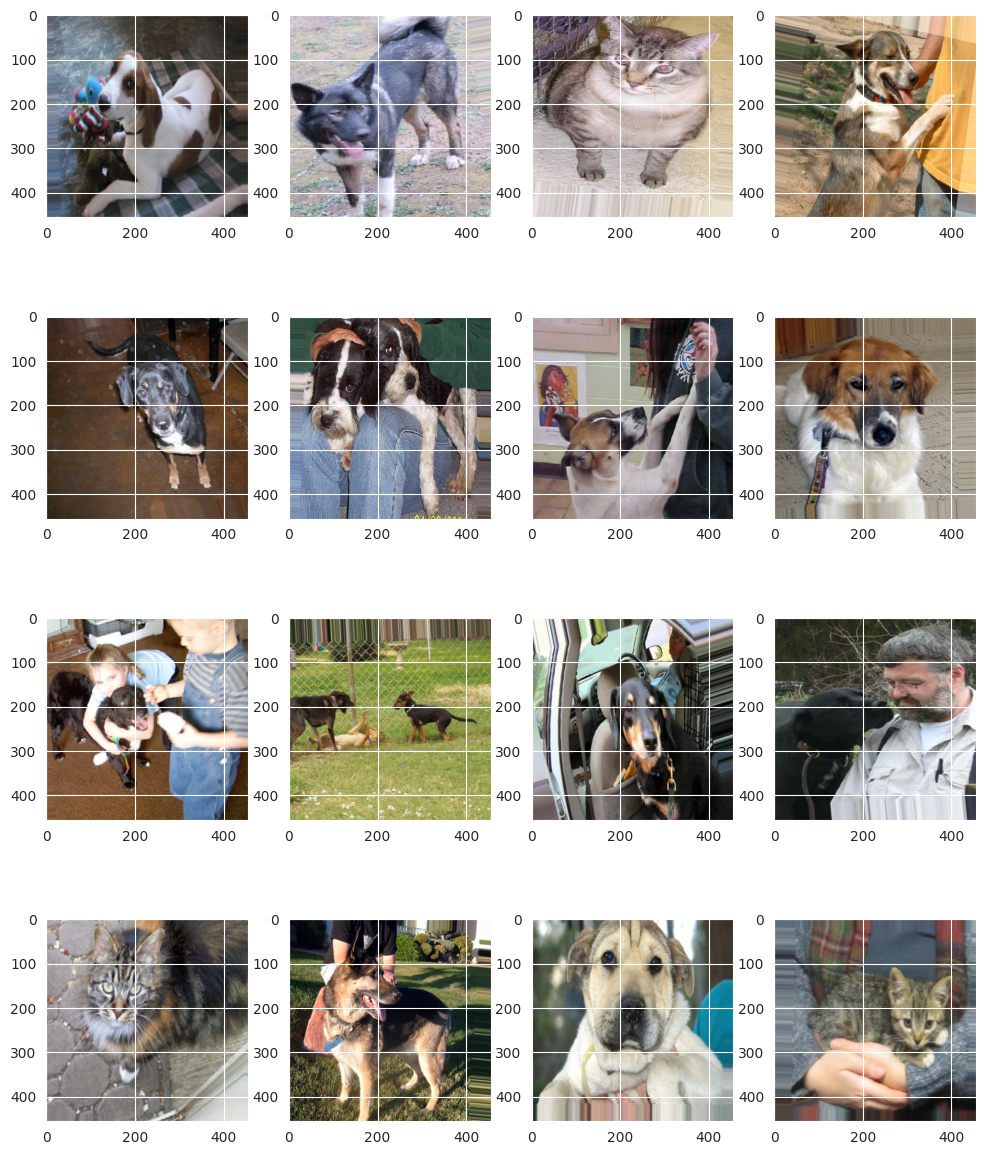

In [21]:
import cv2
import PIL
from PIL import Image

%matplotlib inline
from matplotlib import pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(12, 15))
columns = 4
rows = 4
# x, y = train_generator.next()
x, y = next(train_generator)
for i in range(0, columns*rows):
    image = x[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)
plt.show()

## EfficienNet Model

In [22]:
# loading pretrained conv base model
from efficientnet.keras import EfficientNetB5 as Net

input_shape = (456, 456, 3)
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)
print(f"Input Shape: {input_shape}")

# create new model with a new classification layer
x = conv_base.output
global_average_layer = layers.GlobalAveragePooling2D(name = 'head_pooling')(x)
dropout_layer = layers.Dropout(0.20,name = 'head_dropout')(global_average_layer)
prediction_layer = layers.Dense(2, activation='softmax',name = 'predict_Cat_Dog')(dropout_layer)

### FC layer
model = models.Model(inputs= conv_base.input, outputs=prediction_layer, name = 'EffNet_Cat_Dog')

115515256/115515256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Input Shape: (456, 456, 3)


In [23]:
### Unfreeze FC layer
print('[INFO]: This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))
print('[INFO]: Freezing hidden layers...')
for layer in conv_base.layers:
    layer.trainable = False

print('[INFO]: This is the number of trainable layers '
        'after freezing the conv base:', len(model.trainable_weights))
print('-'*125)

[INFO]: This is the number of trainable layers before freezing the conv base: 506
[INFO]: Freezing hidden layers...
[INFO]: This is the number of trainable layers after freezing the conv base: 2
-----------------------------------------------------------------------------------------------------------------------------


In [24]:
model.summary()

Model: "EffNet_Cat_Dog"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 456, 456, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 228, 228, 48)   │          1,296 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 228, 228, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 228, 228, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 228, 228, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 228, 228, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 228, 228, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 48)       │            624 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 228, 228, 48)   │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 228, 228, 24)   │          1,152 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 228, 228, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization) 

 Total params: 28,517,618 (108.79 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 28,513,520 (108.77 MB)

## Callbacks

- ReduceLROnPlateau : Reduce learning rate when a metric has stopped improving.

In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                              patience=2,
                                              factor=0.5,
                                              min_lr = 0.00001,
                                              verbose = 1)

## Compile the model

In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Reserve 20% of data for validation
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    directory='/content/sample_data/PetImages',  # Path to dataset
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Training subset
)

# Validation data generator
val_generator = train_datagen.flow_from_directory(
    directory='/content/sample_data/PetImages',  # Path to dataset
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Validation subset
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [58]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

lr=1e-4

base_model = EfficientNetB0(
    input_shape=(224, 224, 3),  # Replace with your input shape
    weights='imagenet',         # Use pre-trained weights
    include_top=False           # Exclude the top classification layer
)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)  # Optional: Add dropout for regularization
output = Dense(2, activation='softmax')(x)  # Adjust to match the 2 classes (Cat and Dog)

model = Model(inputs=base_model.input, outputs=output)

#Training
# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.RMSprop(learning_rate=lr),
#               metrics=['acc'])
model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Fit the model

In [59]:
import os

cat_images = len(os.listdir('/content/sample_data/PetImages/Cat'))
dog_images = len(os.listdir('/content/sample_data/PetImages/Dog'))

print(f"Number of valid Cat images: {cat_images}")
print(f"Number of valid Dog images: {dog_images}")


Number of valid Cat images: 12499
Number of valid Dog images: 12499


In [60]:
import os
from PIL import Image

# Path to dataset
base_dir = '/content/sample_data/PetImages'

# Clean both Cat and Dog folders
for category in ['Cat', 'Dog']:
    folder_path = os.path.join(base_dir, category)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Attempt to open the image
            img = Image.open(file_path)
            img.verify()  # Verify that the file is an image
        except (IOError, SyntaxError, ValueError):
            # If the file is invalid, remove it
            print(f"Removing corrupted file: {file_path}")
            os.remove(file_path)


In [61]:
num_epochs = 20
# history_eff = model.fit(train_generator,
#                         epochs = num_epochs,
#                         validation_data = val_generator,
#                         callbacks=learning_rate_reduction)
history_eff = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    callbacks=[learning_rate_reduction]
)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 241s 174ms/step - accuracy: 0.9107 - loss: 0.2008 - val_accuracy: 0.6429 - val_loss: 0.5522 - learning_rate: 1.0000e-04
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 152ms/step - accuracy: 0.9889 - loss: 0.0332 - val_accuracy: 0.4834 - val_loss: 0.6951 - learning_rate: 1.0000e-04
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 152ms/step - accuracy: 0.9954 - loss: 0.0161 - val_accuracy: 0.9478 - val_loss: 0.1490 - learning_rate: 1.0000e-04
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 152ms/step - accuracy: 0.9965 - loss: 0.0096 - val_accuracy: 0.5208 - val_loss: 1.0742 - learning_rate: 1.0000e-04
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9982 - loss: 0.0072
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
625/625 ━━━━━━━━━━━━━━━━━━━━ 95s 153ms/step - accuracy: 0.9982 - loss: 0.0072 - val_accuracy: 0.7611 - val_loss: 0.4817 - learning_rate: 1.0000e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 165ms/

In [62]:
## Set up model path
#Categorical Crossentropy
modelName  = "EffNetB5_CategoricalCrossentropy_Cat_Dog_Classes.h5"
Model2save = f"/content/drive/MyDrive/{modelName}"
model.save(Model2save)
### print
print(f"[INFO]: Save Model as: {Model2save}")
print(f"*"*100)

[INFO]: Save Model as: /content/drive/MyDrive/EffNetB5_CategoricalCrossentropy_Cat_Dog_Classes.h5
****************************************************************************************************


# Plot the results

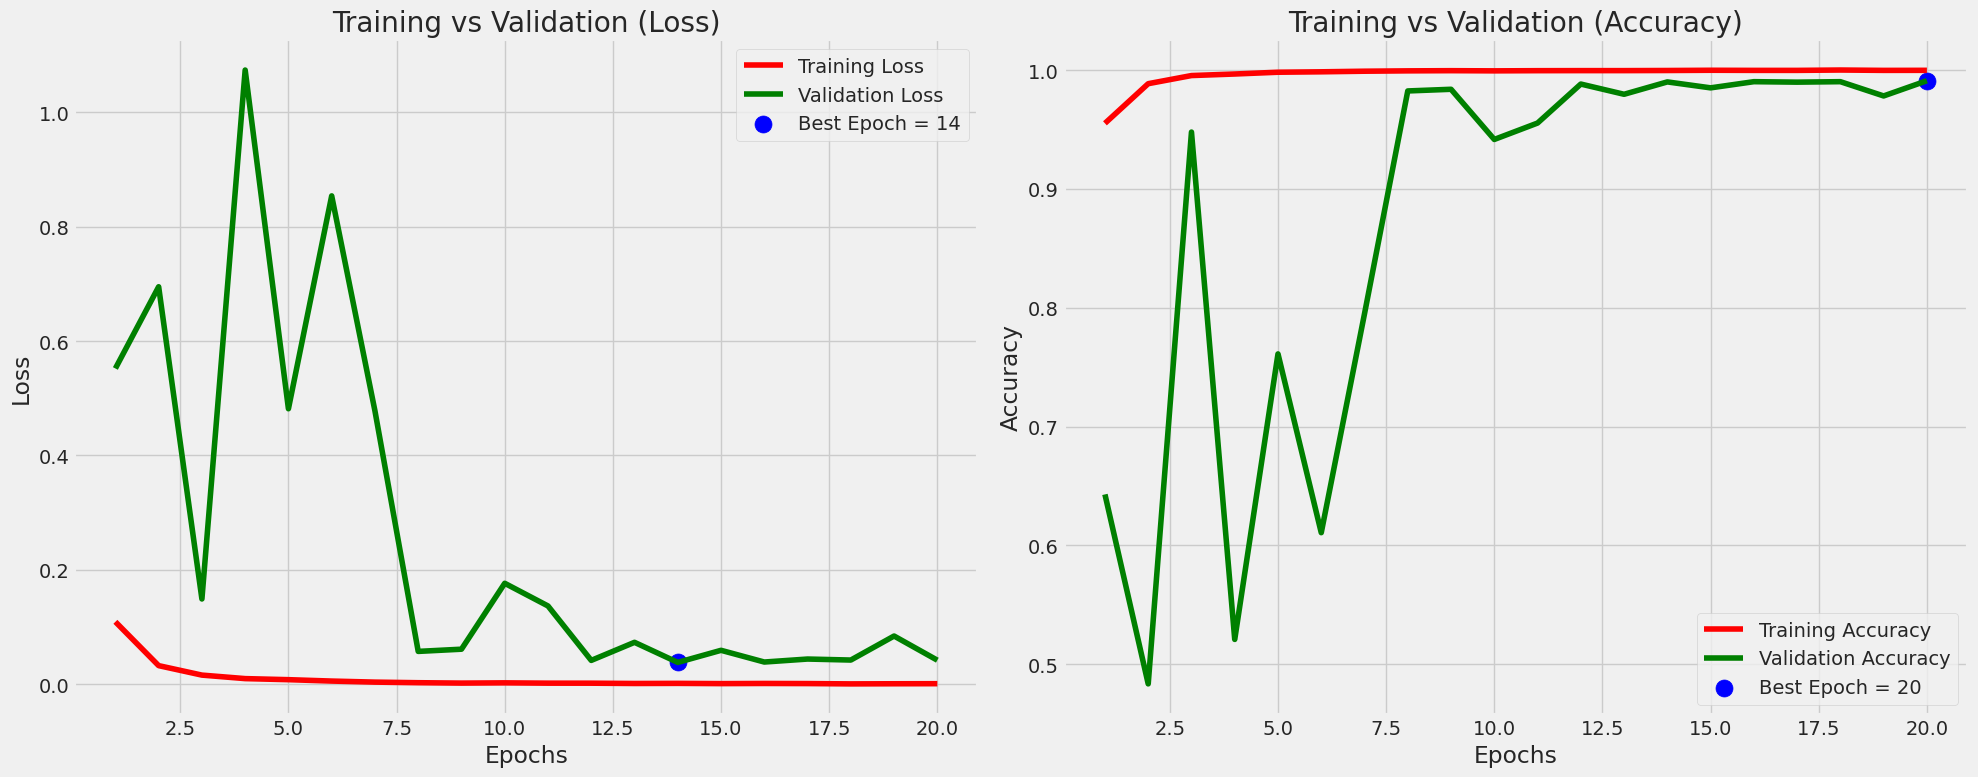

In [65]:
train_acc = history_eff.history['accuracy']
train_loss = history_eff.history['loss']

val_acc = history_eff.history['val_accuracy']
val_loss = history_eff.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluation

In [66]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_generator,batch_size = val_generator, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator,batch_size = val_generator, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


The accuracy of the model for training data is: 99.99499917030334
The Loss of the model for training data is: 0.00010202656994806603
The accuracy of the model for validation data is: 99.09964203834534
The Loss of the model for validation data is: 0.04192640632390976


# Prediction

In [67]:
import os
import numpy as np
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
import tensorflow as tf
import pandas as pd

from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import get_file

## Load model

In [68]:
model_dir = "/content/drive/MyDrive/EffNetB5_CategoricalCrossentropy_Cat_Dog_Classes.h5"
model_B5 = load_model(model_dir)
height = width = model_B5.input_shape[1]
print(height, width)

224 224


In [69]:
model_B5.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_8 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_4           │ (None, 224, 224, 3)    │              7 │ rescaling_8[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_9 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_9[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,052,135 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 2 (12.00 B)

In [70]:
# label_dict = {0: 'Cat', 1: 'Dog'}
# print(label_dict)

label_dict = dict((v,k) for k,v in labels.items())
print(label_dict)

{0: 'Cat', 1: 'Dog'}


In [71]:
def process_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.

    return x

In [82]:
def predict(img_path, model_B5):
    img_x = process_image(img_path)
    predict = model_B5.predict([img_x])
    predict0 = predict[0]
    result = np.argmax(predict0)
    pred_label = label_dict[result]
    pred_prob = predict0[result]

    # print(f"[INFO]: Predict Classes ==> {pred_label} With Probability {pred_prob*100:.4f}%")
    output_network = f"Output network: {pred_label}"
    info = f"[INFO]: Predict Classes ==> {pred_label} With Probability {pred_prob*100:.4f}%"
    return output_network, info

/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_5
Received: inputs=('Tensor(shape=(1, 224, 224, 3))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
[INFO]: Predict Classes ==> Cat With Probability 100.0000%


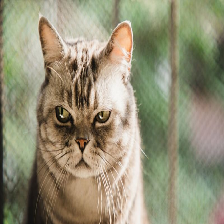

In [74]:
img_path1 = "/content/drive/MyDrive/_119932207_indifferentcatgettyimages.jpg"
predict(img_path1, model_B5)
image.load_img(img_path1, target_size=(height, width))

1/1 [==============================] - 0s 136ms/step
[INFO]: Predict Classes ==> Dog With Probability 97.3297%


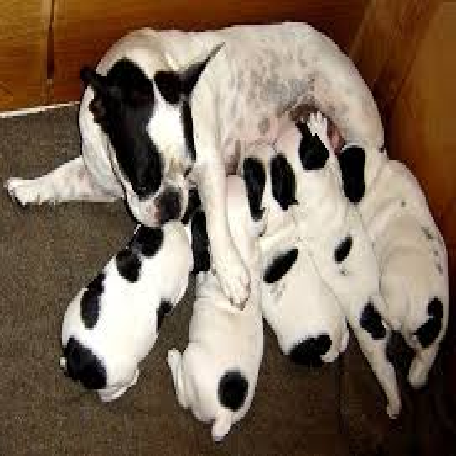

In [ ]:
img_path2 = "/content/drive/MyDrive/images.jpg"
predict(img_path2, model_B5)
image.load_img(img_path2, target_size=(height, width))

1/1 [==============================] - 0s 93ms/step
[INFO]: Predict Classes ==> Cat With Probability 99.9849%


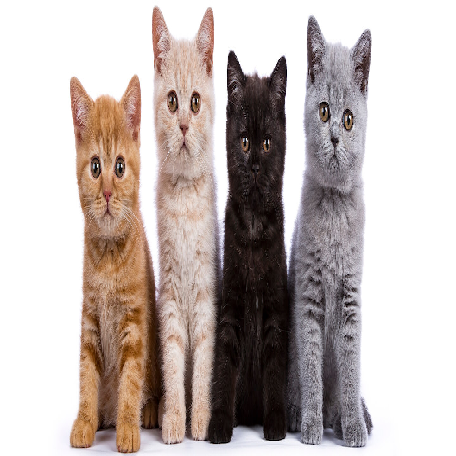

In [ ]:
img_path3 = "/content/drive/MyDrive/Hero Pedigree Cats.jpg"
predict(img_path3, model_B5)
image.load_img(img_path3, target_size=(height, width))

# Exercise

ทดลองนำภาพ นก รถยนต์ เสือ สิงโต และ สุนัขจิ้งจอก มาทำการทำนายและรายงานผลการทำนายแต่ละภาพ

1/1 [==============================] - 0s 99ms/step
[INFO]: Predict Classes ==> Dog With Probability 87.8515%


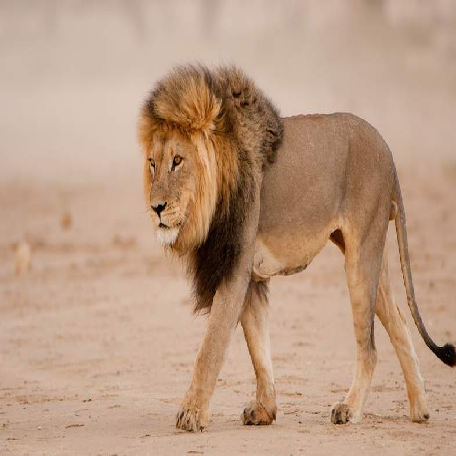

In [ ]:
img_path4 = "/content/drive/MyDrive/black-maned-lion-shem-compion-786x500.jpg"
predict(img_path4, model_B5)
image.load_img(img_path4, target_size=(height, width))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[INFO]: Predict Classes ==> Dog With Probability 99.5299%


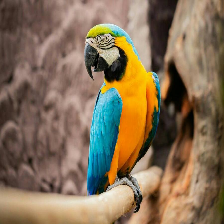

In [84]:
img_path_bird = "/content/drive/MyDrive/bird.jpg"
output_network_bird, info_bird = predict(img_path_bird, model_B5)
print(info_bird)
image.load_img(img_path_bird, target_size=(height, width))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[INFO]: Predict Classes ==> Dog With Probability 99.9648%


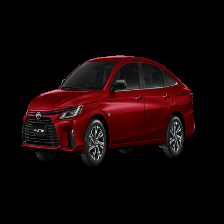

In [86]:
img_path_car = "/content/drive/MyDrive/car.png"
output_network_car, info_car = predict(img_path_car, model_B5)
print(info_car)
image.load_img(img_path_car, target_size=(height, width))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[INFO]: Predict Classes ==> Dog With Probability 63.8203%


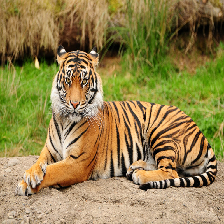

In [88]:
img_path_tiger = "/content/drive/MyDrive/tiger.jpg"
output_network_tiger, info_tiger = predict(img_path_tiger, model_B5)
print(info_tiger)
image.load_img(img_path_tiger, target_size=(height, width))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[INFO]: Predict Classes ==> Dog With Probability 99.9820%


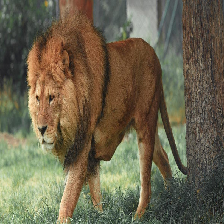

In [89]:
img_path_lion = "/content/drive/MyDrive/lion.jpg"
output_network_lion, info_lion = predict(img_path_lion, model_B5)
print(info_lion)
image.load_img(img_path_lion, target_size=(height, width))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[INFO]: Predict Classes ==> Dog With Probability 99.9933%


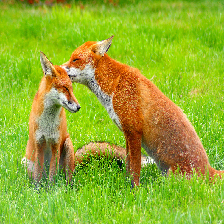

In [90]:
img_path_fox = "/content/drive/MyDrive/fox.jpg"
output_network_fox, info_fox = predict(img_path_fox, model_B5)
print(info_fox)
image.load_img(img_path_fox, target_size=(height, width))

# Exercise

Print output ของ network

In [91]:
print(output_network_bird)
print(output_network_car)
print(output_network_tiger)
print(output_network_lion)
print(output_network_fox)

Output network: Dog
Output network: Dog
Output network: Dog
Output network: Dog
Output network: Dog


--------------------------------------------------------------------------------------

## Evaluating Model Performance

- Confusion matrix

In [92]:
print(X_test.shape)
X_test.head()

(250, 2)


filename label
1095  /content/sample_data/PetImages/Cat/5674.jpg   Cat
1179  /content/sample_data/PetImages/Cat/3685.jpg   Cat
2175  /content/sample_data/PetImages/Dog/1108.jpg   Dog
2269   /content/sample_data/PetImages/Dog/112.jpg   Dog
556   /content/sample_data/PetImages/Cat/8882.jpg   Cat

In [93]:
# label_dict = {0: 'Cat', 1: 'Dog'}
# print(label_dict)

label_dict = dict((v,k) for k,v in labels.items())
print(label_dict)

{0: 'Cat', 1: 'Dog'}


In [94]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])

    return result[0]

In [ ]:
#Predict
pred_list = list()
prob_list = list()
img_path=X_test['filename'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(label_dict[result])
    prob_list.append(predict[result])

1/1 [==============================] - 0s 38ms/step


In [ ]:
predict

array([0.00679942, 0.9932006 ], dtype=float32)

In [ ]:
print(len(pred_list))
print(len(prob_list))

X_test['category'] = pred_list
X_test['Prob'] = prob_list
X_test.head()

250
250


filename label category      Prob
1095    /content/sample_data/PetImages/Cat/184.jpg   Cat      Cat  0.999494
1179  /content/sample_data/PetImages/Cat/11194.jpg   Cat      Cat  0.812446
925    /content/sample_data/PetImages/Dog/8486.jpg   Dog      Dog  0.997590
1019   /content/sample_data/PetImages/Dog/5322.jpg   Dog      Dog  0.998882
556    /content/sample_data/PetImages/Cat/9778.jpg   Cat      Cat  0.999821

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

act = X_test['label'].array
pred = X_test['category'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 99.2%
              precision    recall  f1-score   support

         Cat       0.99      0.99      0.99       125
         Dog       0.99      0.99      0.99       125

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250



## Confusion matrix

Text(0.5, 1.2499999999999805, 'Predicted label')

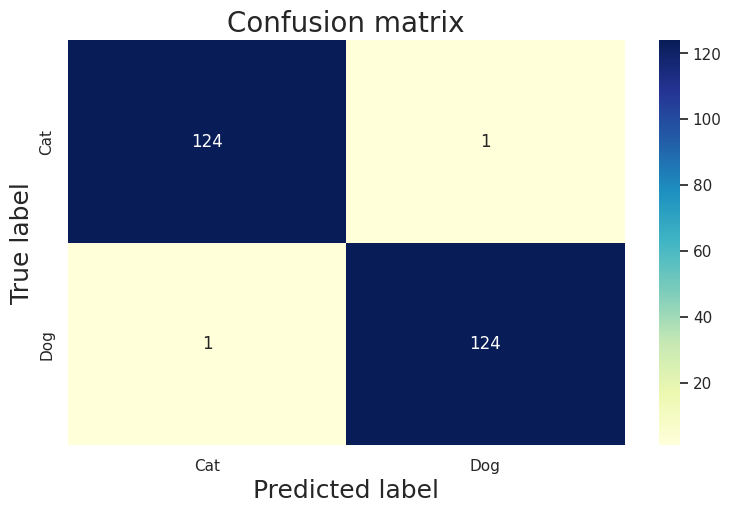

In [ ]:
#create CF
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

---------------------------------------

In [ ]:
img_path=X_test['filename'].tolist()
img_x  = predict_image(img_path[0])
img_x

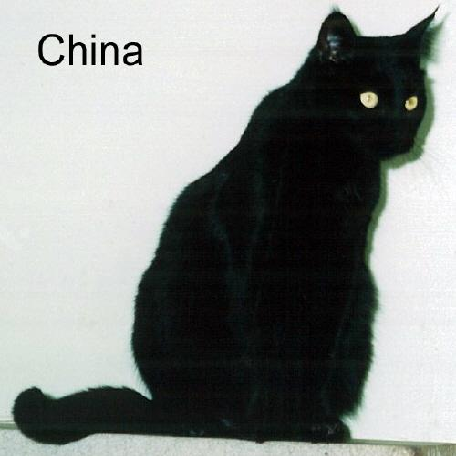

In [ ]:
image.load_img(img_path[0], target_size=(height, width))